Challenge `conv-op` is effective DA method, but cannot applied to un-structured data such as point cloud. 

Possible solutions:
- Point-Cloud -> volumetric (tobe specific about voxels)
- (Forgo point cloud completely?) Multiview image observation of real-object (?)

Renale of the paper:

To deal with _unordered data_, 

Order: the way to arrange _multiple_ objects.

Data in this case must have multiple components. 

An individual _data sample_ in most learning problems is an atomic object, doesn't have internal structure or multiple components.

Each data sample contains multiple objects -- points, in this study, and the order of those objects is not part of the observation -- the data can come with any order.




In [ ]:
import torch
import numpy as np
rng = np.random.RandomState(0)
point_cloud_0 = rng.rand(900, 3)

In [67]:
point_cloud_0a = point_cloud_0[rng.permutation(900)]

In [48]:
# pretended ground-truth class ID
gnd = [30]

We are seeking a processing model $f$, so $f(pc_0) = f(pc_{0a})$

__Point-to-Point__ Relation

Although the objects in one data sample are not ordered, but they are _related_, and the assumption is that the relationship is partially determined by the Eculidean distance between the the objects.

Motivation behind the so-called convolution-like operation on point clouds. 

Analogy: pixels in an image are related, the relationship between nearby ones can be captured by convolutional kernels. But to apply this scheme to PC's is NOT straightforward, as the concept of being "nearby" in a PC is flexible, and the number and format of neighbourhood of individual points is not fixed, as opposed to that for individual pixels.


We don't evaluate a PC of 1,000 points as follows:
> $x_1$ should be in position-1, $x_2$ is at position-2, ....

Rather the model should be descriptive like:
> given a central point $x_c$, the neighbourhood has the composition like position-1, position-2 ...



Let the model be $f$. We want the $f(X) = f(T(X))$, where $T: \mathbb{R}^{n \times 3} \mapsto \mathbb{R}^{n \times 3}$ is a global geometric transformation on a set of points.

What is the output of $f$? $ \{x_1, \dots, x_{1000}\}  \mapsto \{1, 2, \dots, C\}$, say a classifier.

## Try to design an $f$ satisfying 3 props

In [11]:
import torch.nn as nn

In [43]:
MLP_OUT_DIM = 128
CLASS_NUM = 40
class MyPointNet(nn.Module):
    def __init__(self):
        super(MyPointNet, self).__init__()
        self.mlp = \
            nn.Sequential(
                nn.Linear(in_features=3,
                          out_features=64),
                nn.ReLU(),
            nn.Linear(in_features=64,
                      out_features=MLP_OUT_DIM),
        )
        self.classifier_head = nn.Sequential(
            nn.Linear(in_features=MLP_OUT_DIM, 
                      out_features=MLP_OUT_DIM),
            nn.ReLU(),
            nn.Linear(in_features=MLP_OUT_DIM, 
                      out_features=CLASS_NUM)
        ) # sequential
        
        
        
    def forward(self, pc):
        """
        :param pc: an array of m x n x 3
        """
        # order PC?
        # how let's pretend it were ordered.
        sample_num, point_num, coord_dim = pc.shape
        assert coord_dim == 3, f"unsupported point cloud of dim {coord_dim}"
        features = self.mlp(pc.view(-1, 3))\
            .reshape(sample_num, point_num, MLP_OUT_DIM)
        # aggregate the features:
        pc_feat = torch.max(features, dim=1)[0]
        # classific
        out = self.classifier_head(pc_feat)
        return out

In [68]:
pnet = MyPointNet()

In [69]:
point_cloud_0_tensor = torch.Tensor(point_cloud_0)\
    .unsqueeze(0)
print(point_cloud_0_tensor.shape)
pred = pnet(point_cloud_0_tensor)
print(pred.shape)

torch.Size([1, 900, 3])
torch.Size([1, 40])


In [51]:
gnd_tensor = torch.LongTensor(gnd)
lss = nn.functional.nll_loss(pred, gnd_tensor)

In [60]:
optim = torch.optim.Adam(pnet.parameters(), lr=0.0001)
for epoch in range(1000):
    optim.zero_grad()
    pred = pnet(point_cloud_0_tensor)
    lss = nn.functional.nll_loss(pred, gnd_tensor)
    lss.backward()
    optim.step()
    print(lss)


tensor(-0.0949, grad_fn=<NllLossBackward>)
tensor(-0.1073, grad_fn=<NllLossBackward>)
tensor(-0.1197, grad_fn=<NllLossBackward>)
tensor(-0.1323, grad_fn=<NllLossBackward>)
tensor(-0.1450, grad_fn=<NllLossBackward>)
tensor(-0.1577, grad_fn=<NllLossBackward>)
tensor(-0.1705, grad_fn=<NllLossBackward>)
tensor(-0.1835, grad_fn=<NllLossBackward>)
tensor(-0.1966, grad_fn=<NllLossBackward>)
tensor(-0.2097, grad_fn=<NllLossBackward>)
tensor(-0.2228, grad_fn=<NllLossBackward>)
tensor(-0.2361, grad_fn=<NllLossBackward>)
tensor(-0.2493, grad_fn=<NllLossBackward>)
tensor(-0.2620, grad_fn=<NllLossBackward>)
tensor(-0.2748, grad_fn=<NllLossBackward>)
tensor(-0.2875, grad_fn=<NllLossBackward>)
tensor(-0.3003, grad_fn=<NllLossBackward>)
tensor(-0.3130, grad_fn=<NllLossBackward>)
tensor(-0.3258, grad_fn=<NllLossBackward>)
tensor(-0.3386, grad_fn=<NllLossBackward>)
tensor(-0.3516, grad_fn=<NllLossBackward>)
tensor(-0.3645, grad_fn=<NllLossBackward>)
tensor(-0.3773, grad_fn=<NllLossBackward>)
tensor(-0.3

tensor(-17.1024, grad_fn=<NllLossBackward>)
tensor(-17.3289, grad_fn=<NllLossBackward>)
tensor(-17.5577, grad_fn=<NllLossBackward>)
tensor(-17.7889, grad_fn=<NllLossBackward>)
tensor(-18.0226, grad_fn=<NllLossBackward>)
tensor(-18.2589, grad_fn=<NllLossBackward>)
tensor(-18.4975, grad_fn=<NllLossBackward>)
tensor(-18.7386, grad_fn=<NllLossBackward>)
tensor(-18.9822, grad_fn=<NllLossBackward>)
tensor(-19.2283, grad_fn=<NllLossBackward>)
tensor(-19.4770, grad_fn=<NllLossBackward>)
tensor(-19.7285, grad_fn=<NllLossBackward>)
tensor(-19.9825, grad_fn=<NllLossBackward>)
tensor(-20.2392, grad_fn=<NllLossBackward>)
tensor(-20.4984, grad_fn=<NllLossBackward>)
tensor(-20.7604, grad_fn=<NllLossBackward>)
tensor(-21.0249, grad_fn=<NllLossBackward>)
tensor(-21.2921, grad_fn=<NllLossBackward>)
tensor(-21.5620, grad_fn=<NllLossBackward>)
tensor(-21.8345, grad_fn=<NllLossBackward>)
tensor(-22.1096, grad_fn=<NllLossBackward>)
tensor(-22.3875, grad_fn=<NllLossBackward>)
tensor(-22.6680, grad_fn=<NllLos

tensor(-196.8757, grad_fn=<NllLossBackward>)
tensor(-198.3130, grad_fn=<NllLossBackward>)
tensor(-199.7579, grad_fn=<NllLossBackward>)
tensor(-201.2104, grad_fn=<NllLossBackward>)
tensor(-202.6705, grad_fn=<NllLossBackward>)
tensor(-204.1383, grad_fn=<NllLossBackward>)
tensor(-205.6139, grad_fn=<NllLossBackward>)
tensor(-207.0971, grad_fn=<NllLossBackward>)
tensor(-208.5882, grad_fn=<NllLossBackward>)
tensor(-210.0870, grad_fn=<NllLossBackward>)
tensor(-211.5937, grad_fn=<NllLossBackward>)
tensor(-213.1082, grad_fn=<NllLossBackward>)
tensor(-214.6305, grad_fn=<NllLossBackward>)
tensor(-216.1607, grad_fn=<NllLossBackward>)
tensor(-217.6989, grad_fn=<NllLossBackward>)
tensor(-219.2449, grad_fn=<NllLossBackward>)
tensor(-220.7990, grad_fn=<NllLossBackward>)
tensor(-222.3609, grad_fn=<NllLossBackward>)
tensor(-223.9309, grad_fn=<NllLossBackward>)
tensor(-225.5090, grad_fn=<NllLossBackward>)
tensor(-227.0950, grad_fn=<NllLossBackward>)
tensor(-228.6892, grad_fn=<NllLossBackward>)
tensor(-23

tensor(-842.6934, grad_fn=<NllLossBackward>)
tensor(-846.8210, grad_fn=<NllLossBackward>)
tensor(-850.9631, grad_fn=<NllLossBackward>)
tensor(-855.1197, grad_fn=<NllLossBackward>)
tensor(-859.2910, grad_fn=<NllLossBackward>)
tensor(-863.4768, grad_fn=<NllLossBackward>)
tensor(-867.6774, grad_fn=<NllLossBackward>)
tensor(-871.8926, grad_fn=<NllLossBackward>)
tensor(-876.1225, grad_fn=<NllLossBackward>)
tensor(-880.3672, grad_fn=<NllLossBackward>)
tensor(-884.6266, grad_fn=<NllLossBackward>)
tensor(-888.9008, grad_fn=<NllLossBackward>)
tensor(-893.1898, grad_fn=<NllLossBackward>)
tensor(-897.4938, grad_fn=<NllLossBackward>)
tensor(-901.8124, grad_fn=<NllLossBackward>)
tensor(-906.1461, grad_fn=<NllLossBackward>)
tensor(-910.4947, grad_fn=<NllLossBackward>)
tensor(-914.8583, grad_fn=<NllLossBackward>)
tensor(-919.2369, grad_fn=<NllLossBackward>)
tensor(-923.6305, grad_fn=<NllLossBackward>)
tensor(-928.0392, grad_fn=<NllLossBackward>)
tensor(-932.4630, grad_fn=<NllLossBackward>)
tensor(-93

tensor(-2325.0684, grad_fn=<NllLossBackward>)
tensor(-2333.6516, grad_fn=<NllLossBackward>)
tensor(-2342.2571, grad_fn=<NllLossBackward>)
tensor(-2350.8857, grad_fn=<NllLossBackward>)
tensor(-2359.5371, grad_fn=<NllLossBackward>)
tensor(-2368.2114, grad_fn=<NllLossBackward>)
tensor(-2376.9087, grad_fn=<NllLossBackward>)
tensor(-2385.6287, grad_fn=<NllLossBackward>)
tensor(-2394.3718, grad_fn=<NllLossBackward>)
tensor(-2403.1379, grad_fn=<NllLossBackward>)
tensor(-2411.9270, grad_fn=<NllLossBackward>)
tensor(-2420.7390, grad_fn=<NllLossBackward>)
tensor(-2429.5742, grad_fn=<NllLossBackward>)
tensor(-2438.4326, grad_fn=<NllLossBackward>)
tensor(-2447.3142, grad_fn=<NllLossBackward>)
tensor(-2456.2190, grad_fn=<NllLossBackward>)
tensor(-2465.1467, grad_fn=<NllLossBackward>)
tensor(-2474.0974, grad_fn=<NllLossBackward>)
tensor(-2483.0723, grad_fn=<NllLossBackward>)
tensor(-2492.0698, grad_fn=<NllLossBackward>)
tensor(-2501.0911, grad_fn=<NllLossBackward>)
tensor(-2510.1350, grad_fn=<NllLos

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt


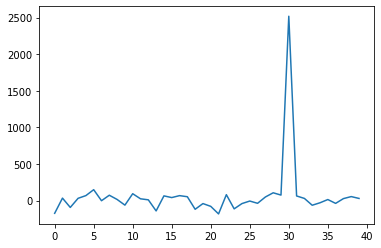

In [65]:
plt.plot(pred.detach().numpy().squeeze())